<a href="https://colab.research.google.com/github/kty3452/ML-Class/blob/main/week9/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alcohol_Sales.csv')
data = df['S4248SM144NCEN'].values.reshape(-1,1)


In [33]:

# 2. 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(data)



In [34]:
from sklearn.model_selection import train_test_split
import numpy as np

window = 12   # 최근 12개월 → 다음달 예측
X, y = [], []
for i in range(len(data) - window):
    X.append(data[i:i + window])
    y.append(data[i + window])

X, y = np.array(X), np.array(y)

# --- 트레인 / 테스트 분할 ---
# 시계열이라면 shuffle=False로 설정해야 순서가 유지됨
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(250, 12, 1) (63, 12, 1)
(250, 1) (63, 1)


In [35]:
import tensorflow as tf

# (앞에서 만든) X_train, X_test, y_train, y_test가 있다고 가정
# SimpleRNN 입력형태로 리쉐이프
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

window = X_train.shape[1]  # 입력 시퀀스 길이

# 1) 모델 정의
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(window, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

# 2) 컴파일
model_rnn.compile(optimizer='adam', loss='mse')

# 3) 콜백(선택): 과적합 방지
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)

# 4) 학습
history = model_rnn.fit(
    X_train_rnn, y_train,
    validation_data=(X_test_rnn, y_test),
    epochs=50,
    batch_size=8,
    verbose=1,
    callbacks=[early_stop]
)



Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0345 - val_loss: 0.0630
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0263
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0215
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0157
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 0.0097
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 0.0116
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0092
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.9626e-04 - val_loss: 0.0067
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2447e-04 - val_loss: 0.0051
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6996e-04 - val_loss: 0.0111
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0069
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - v

In [36]:
# 5) 성능 평가
test_loss = model_rnn.evaluate(X_test_rnn, y_test, verbose=0)
print(f"Test MSE: {test_loss:.6f}")


Test MSE: 0.003665


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


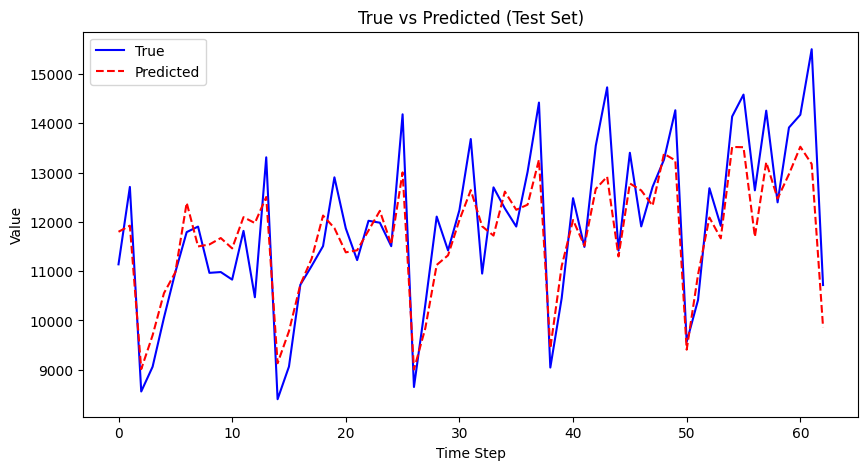

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 테스트셋 예측
pred = model_rnn.predict(X_test_rnn)

# 역정규화 (y가 정규화된 상태라고 가정)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(pred)

# 그래프 시각화
plt.figure(figsize=(10,5))
plt.plot(y_true, label='True', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('True vs Predicted (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² : {r2:.4f}")


MSE: 570124.6685
MAE: 618.3425
R² : 0.7880


In [39]:
import tensorflow as tf
import numpy as np

# (앞에서 만든) X_train, X_test, y_train, y_test가 있다고 가정
# LSTM 입력형태로 리쉐이프: (samples, timesteps=window, features=1)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

window = X_train.shape[1]  # 앞 단계의 window와 동일해야 함

# 1) 모델 정의
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window, 1)),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# 2) 콜백(선택): 과적합 방지
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)

# 3) 학습: train만 사용, 검증은 test로
history = model_lstm.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=50,
    batch_size=8,
    verbose=1,
    callbacks=[early_stop]
)



Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0617 - val_loss: 0.0447
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - val_loss: 0.0152
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0153
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0153
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 0.0202
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0143
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0150
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0137
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - val_loss: 0.0137
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0183
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0142
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 0.0181

In [40]:

# 4) 성능 확인
test_loss = model_lstm.evaluate(X_test_lstm, y_test, verbose=0)
print(f"Test MSE: {test_loss:.6f}")

Test MSE: 0.011038


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


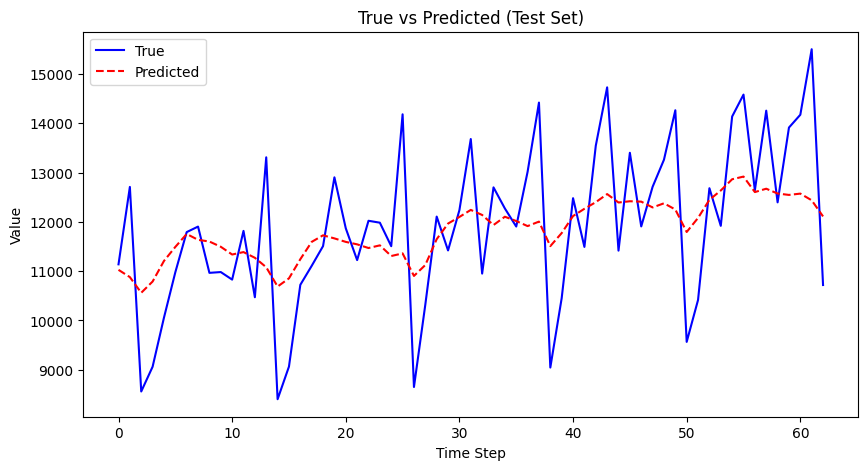

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# 테스트셋 예측
pred = model_lstm.predict(X_test_rnn)

# 역정규화 (y가 정규화된 상태라고 가정)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(pred)

# 그래프 시각화
plt.figure(figsize=(10,5))
plt.plot(y_true, label='True', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('True vs Predicted (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² : {r2:.4f}")


MSE: 1717238.3952
MAE: 1053.3406
R² : 0.3614
